In [166]:


# prompt: ---------------------------------------------------------------------------
# TypeError                                 Traceback (most recent call last)
#  in ()
# ----> 1 path = kagglehub.dataset_download("salader/dogs-vs-cats", unzip=True)
#       2
#       3 print("Path to dataset files:", path)
# TypeError: dataset_download() got an unexpected keyword argument 'unzip'

from google.colab import drive
!pip install kaggle

In [167]:
!mkdir -p ~/.kaggle
!cp  /content/kaggle.json ~/.kaggle/

In [168]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [169]:
import zipfile
zip = zipfile.ZipFile('/content/utkface-new.zip')
zip.extractall()
zip.close()

In [170]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [171]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [172]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [173]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [174]:
df.shape

(23708, 3)

In [175]:
df.head()

age  gender                                    img
0   37       0  37_0_0_20170117140102778.jpg.chip.jpg
1   24       1  24_1_3_20161220222118601.jpg.chip.jpg
2   25       0  25_0_3_20170119144603197.jpg.chip.jpg
3   37       1  37_1_0_20170104183404469.jpg.chip.jpg
4   41       1  41_1_0_20170104185117127.jpg.chip.jpg

In [176]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [177]:
train_df.shape

(20000, 3)

In [178]:
test_df.shape

(3708, 3)

In [179]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [192]:
# Preprocessing function to return dictionary format
def multi_output_generator(generator):
    while True:
        x_batch, y_batch = next(generator)  # Corrected next() call
        yield x_batch, {"age": y_batch[:, 0], "gender": y_batch[:, 1]}

In [193]:
# Load data using flow_from_dataframe
train_generator_base = train_datagen.flow_from_dataframe(train_df,
                                                         directory=folder_path,
                                                         x_col='img',
                                                         y_col=['age', 'gender'],
                                                         target_size=(200, 200),
                                                         class_mode='raw',  # Outputs raw values, required for regression/classification
                                                         batch_size=32)

test_generator_base = test_datagen.flow_from_dataframe(test_df,
                                                       directory=folder_path,
                                                       x_col='img',
                                                       y_col=['age', 'gender'],
                                                       target_size=(200, 200),
                                                       class_mode='raw',
                                                       batch_size=32)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [194]:
# Wrap in multi-output format
train_generator = multi_output_generator(train_generator_base)
test_generator = multi_output_generator(test_generator_base)

In [195]:
import tensorflow.keras

In [196]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [197]:
vggnet = VGG16(include_top=False, input_shape=(200,200,3))

In [198]:
vggnet.trainable=False

output = vggnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [199]:
model = Model(inputs=vggnet.input,outputs=[output1,output2])

In [200]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 200, 200, 64)   │          1,792 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 200, 200, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 100, 100, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 100, 100, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 100, 100, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 50, 50, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 50, 50, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 50, 50, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 50, 50, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 25, 25, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 25, 25, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 25, 25, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 25, 25, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 12, 12, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 12, 12, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 12, 12, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 34,116,418 (130.14 MB)

 Trainable params: 19,401,730 (74.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

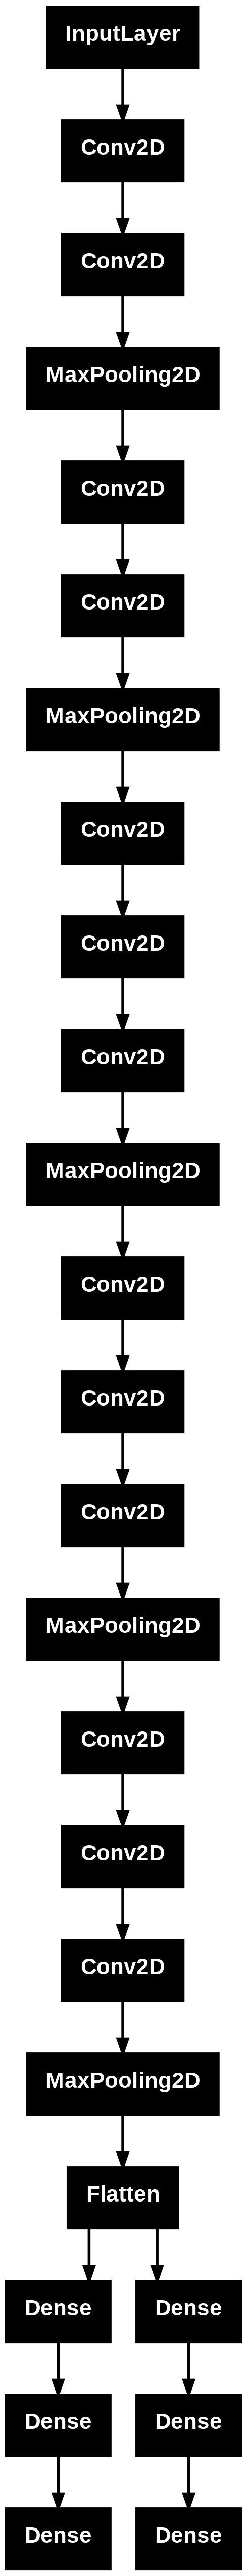

In [201]:
from keras.utils import plot_model
plot_model(model)

In [202]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [ ]:
# Train model
model.fit(train_generator,
          steps_per_epoch=len(train_df) // 32,
          epochs=2,
          validation_data=test_generator,
          validation_steps=len(test_df) // 32)

Epoch 1/2
